In [238]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]


In [239]:
data_dir = './training-data'
BATCH_SIZE = 32
img_height = 180
img_width = 180


In [240]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE)

Found 62 files belonging to 7 classes.
Using 50 files for training.


In [241]:
class_names = train_dataset.class_names


In [242]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE)

Found 62 files belonging to 7 classes.
Using 12 files for validation.


In [243]:
# try calssifier

In [244]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [245]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [246]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.8923629


In [247]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

In [248]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [249]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [250]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_11 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_15 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                               

In [251]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
2/2 [==============================] - 1s 265ms/step - loss: 3.1573 - accuracy: 0.1600 - val_loss: 2.5222 - val_accuracy: 0.0833
Epoch 2/20
2/2 [==============================] - 0s 184ms/step - loss: 2.0168 - accuracy: 0.1400 - val_loss: 1.9806 - val_accuracy: 0.4167
Epoch 3/20
2/2 [==============================] - 0s 181ms/step - loss: 1.8971 - accuracy: 0.2200 - val_loss: 1.9967 - val_accuracy: 0.0833
Epoch 4/20
2/2 [==============================] - 0s 181ms/step - loss: 1.8981 - accuracy: 0.2000 - val_loss: 1.9675 - val_accuracy: 0.0833
Epoch 5/20
2/2 [==============================] - 0s 118ms/step - loss: 1.8613 - accuracy: 0.2000 - val_loss: 1.8894 - val_accuracy: 0.1667
Epoch 6/20
2/2 [==============================] - 0s 185ms/step - loss: 1.8203 - accuracy: 0.3200 - val_loss: 1.8588 - val_accuracy: 0.3333
Epoch 7/20
2/2 [==============================] - 0s 119ms/step - loss: 1.7749 - accuracy: 0.3400 - val_loss: 1.8938 - val_accuracy: 0.4167
Epoch 8/20
2/2 [====

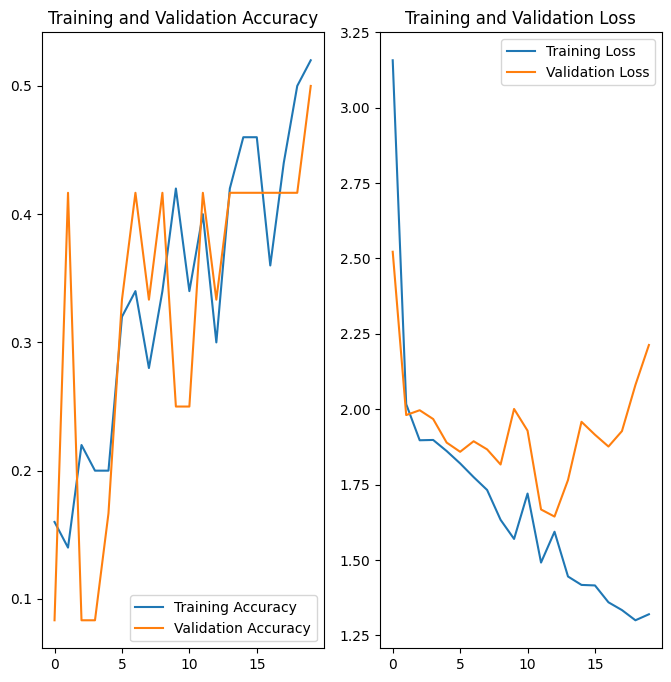

In [252]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [257]:
fullPath = os.path.abspath("./testimage1.jpeg")  # or similar, depending on your scenario
sunflower_path = tf.keras.utils.get_file('./testimage1.jpeg', 'file://'+fullPath)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 60ms/step
This image most likely belongs to type-6 with a 46.23 percent confidence.
